<a id="top"></a>
# Classifying flaring stars with stella: a convolutional neural network for TESS

***

## Learning Goals


**In this tutorial, you will see an example of building, compiling, and training a CNN to classify astronomical data in vector form.**
By the end of this tutorial you will have a working example of a simple Convolutional Neural Network (CNN) in `Keras`.

## Introduction
CNNs are a class of machine learning (ML) algorithms that can extract information from data. In this notebook, you will walk through the basic steps of applying a CNN to data:
1. Load the data and visualize a sample of the data.
2. Divide the data into training, validation, and testing sets.
3. Build a CNN in `Keras`.
4. Compile the CNN.
5. Train the CNN to perform a classification task.
6. Evaluate the CNN performance on test data with a confusion matrix.
7. Build a new, unlabeled dataset and apply the CNN.


CNNs can be applied to a wide range of vector analysis tasks, including classification and regression.
Here, we will build, compile, and train CNN to classify whether a star has undergone a flaring event from its observed TESS 2-minute light curve, and where the flaring events are located within the time series.
This work is based on the model described in the [`stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) software package.

**NOTE:** *The [`stella` team has publicly-available code and documentation](https://adina.feinste.in/stella/) for demonstrating the architecture and optimal performance of this model, which we encourage you to check out!
The goal of this notebook is to step through the model building and training process.* 

## Imports
This notebook uses the following:
- `numpy` to handle array functions
- `tarfile` for unpacking files
- `astropy` for accessing FITS files
- `matplotlib.pyplot` for plotting data
- `stella` for generating the training set and processing data
- `keras` for building the CNN
- `sklearn` for model performance metrics
- `lightkurve.search` for extracting light curves

If you do not have these packages installed, you can install them using `pip` or `conda`.
You can refer to the webpages for each of those modules for further installation instructions.

To download the `stella` package, see their [documentation](https://adina.feinste.in/stella/getting_started/installation.html).

To download the `lightkurve` package, see their [documentation](https://docs.lightkurve.org/about/install.html).

In [1]:
# arrays
import numpy as np

# unpacking files
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)


## Convolutional Neural Network (CNN)  for Vector Classification

### 1. Download the training data using `stella`

Load the sample of TESS lightcurves (input vectors) and flare classifications (output labels) to be used to train the CNN from the [`stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) package.
`stella` pre-processes the light curves and splits the data into training, test and validation sets.

The training set contains stars observed at 2-minute cadence in TESS Sectors 1 and 2, classified by hand and presented as a flare catalog by <a href='https://ui.adsabs.harvard.edu/abs/2020AJ....159...60G/abstract'>Gunther et al. 2020</a>.
The light curves are processed into examples of length 200 cadences, where each flaring event, if present, is located at the center of the example. The full sample of lightcurves contains 8694 positive classes (flare), and 35896 negative classes (no flare).
For this notebook, we will download a subset of this sample.
These data are described in [Feinstein et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract).

The CNN will be used to predict the presence of flaring events as a function of observing cadence.
The input to the CNN is a light curve (time, flux, and flux error) and the output is a "probability light curve", or probabilities (value between 0 and 1) that the measurement at each cadence is of a flaring event (1=flare, 0=no flare).
In other words, the CNN performs a **classification** task at each cadence.
Before a probability light curve can be produced, `stella` first pre-processes the input light curve by assembling it into examples of length 200 cadences, so that the model can predict a value for the flare probability at each valid cadence.

In [2]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

# open file
file = tarfile.open(download_file(file_url, cache=True))
  
# extracting file
file.extractall('.')
file.close()

CPU times: user 212 ms, sys: 61.1 ms, total: 273 ms
Wall time: 290 ms


In [3]:
# build train, test, validation dataset, "ds"
data_dir = './hellouniverse_stella_500/'

ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 174.19it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



The `stella` dataset includes training, test and validation lightcurves (input vectors) and flare labels (output labels).
`stella` applies the necessary pre-processing to the lightcurves for input to the CNN model.
For more on how these are constructed, see [Feinstein et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract).
For our purposes (i.e., building the `stella` CNN from scratch to illustrate its structure and function), we first need to remove all lightcurves from the training, test and validation sets with NaN-valued inputs.
To do this, we loop through the data and select only lightcurves without NaNs.

In [4]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

To visualize the structure of the lightcurves in the training set, we plot a random selection of 16 examples:

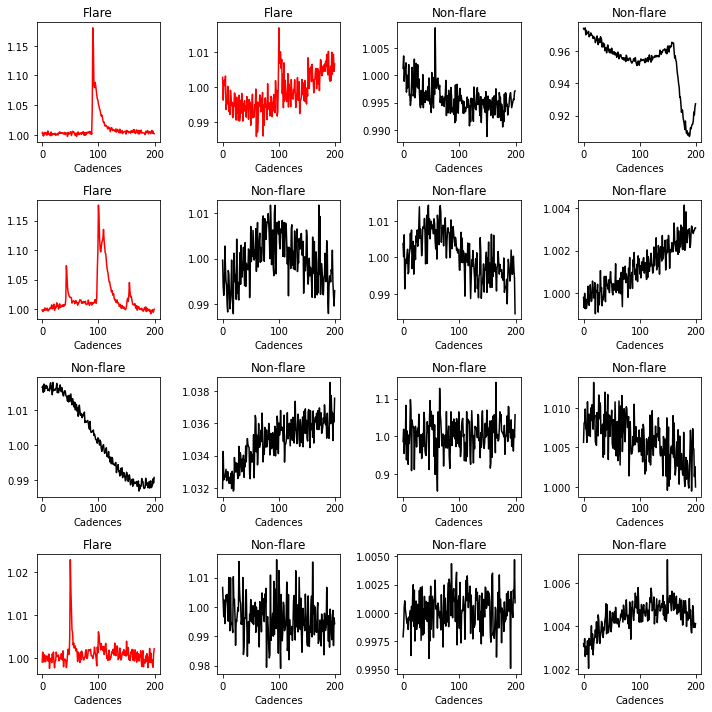

In [5]:
# select random image indices:
example_ids = np.random.choice(len(ds.train_labels), 16)

# pull the lightcurves and labels for these selections
example_lightcurves = [ds.train_data[j] for j in example_ids]
example_labels = [ds.train_labels[j] for j in example_ids]


# initialize your figure
fig = plt.figure(figsize=(10, 10))

# loop through the randomly selected images and plot with labels
colors = {1: 'r', 0: 'k'}
titles = {1: 'Flare', 0: 'Non-flare'}
for i in range(len(example_ids)):
    plt.subplot(4, 4, i + 1)
    plt.plot(example_lightcurves[i], color=colors[example_labels[i]])
    plt.title(titles[example_labels[i]])
    plt.xlabel('Cadences')
    
plt.tight_layout()
plt.show()

### 3. Build a CNN in `Keras`

Here, we will build the CNN model described in [Feinstein et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract) and implemented in `stella` from scratch.

Further details about Conv1D, MaxPooling1D, BatchNormalization, Dropout, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).
Further details about the sigmoid and softmax activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [6]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

seed = 2
np.random.seed(seed)

filter1 = 16
filter2 = 64
dense = 32
dropout = 0.1

# Define architecture for model
data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)

cnn = Model(inputs=x_in, outputs=y_out)

2022-06-02 09:28:34.440376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 4. Compile the CNN

Next, we compile the model.
As in [Feinstein et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract), we select the Adam optimizer and the binary cross entropy loss function (as this is a binary classification problem).

You can learn more about [optimizers](https://keras.io/api/optimizers/) and more about [loss functions for regression tasks](https://keras.io/api/losses/) in the [Keras documentation](https://keras.io/).

In [7]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 7)            119       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 7)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 7)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 3)            0         
 1D)                                                         

### 5. Train the CNN to perform a classification task

We will start with training for 20 epochs, but this almost certainly won't be long enough to get great results.
Once you've run your model and evaluated the fit, you can come back here and run the next cell again for 100 epochs or longer.  

You can learn more about `fit` [here](https://keras.rstudio.com/reference/fit.html).

In [8]:
nb_epoch = 20
batch_size = 64
shuffle = True

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/20
23/23 [==============================] - 2s 30ms/step - loss: 0.6105 - accuracy: 0.7247 - val_loss: 0.6087 - val_accuracy: 0.7088
Epoch 2/20
23/23 [==============================] - 0s 15ms/step - loss: 0.5960 - accuracy: 0.7309 - val_loss: 0.6074 - val_accuracy: 0.7088
Epoch 3/20
23/23 [==============================] - 0s 15ms/step - loss: 0.5929 - accuracy: 0.7302 - val_loss: 0.6090 - val_accuracy: 0.7088
Epoch 4/20
23/23 [==============================] - 0s 15ms/step - loss: 0.5840 - accuracy: 0.7316 - val_loss: 0.6011 - val_accuracy: 0.7088
Epoch 5/20
23/23 [==============================] - 0s 14ms/step - loss: 0.5824 - accuracy: 0.7316 - val_loss: 0.5974 - val_accuracy: 0.7088
Epoch 6/20
23/23 [==============================] - 0s 14ms/step - loss: 0.5773 - accuracy: 0.7343 - val_loss: 0.5929 - val_accuracy: 0.7143
Epoch 7/20
23/23 [==============================] - 0s 15ms/step - loss: 0.5733 - accuracy: 0.7363 - val_loss: 0.5897 - val_accuracy: 0.7143
Epoch 8/20
23

In [9]:
# save the model to file
cnn_file = 'flare_model.h5'
cnn.save(cnn_file)

### 6. Test the CNN performance 

Apply the CNN to predict flares on the "test" set, not used for training or validating the CNN, and evaluate the performance using a confusion matrix.
See the documentation from [sklearn on confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for more information.
The code for generating and plotting the confusion matrix below was adapted from the application by [Ciprijanovic et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) for [DeepMerge](https://github.com/deepskies/deepmerge-public).

In [10]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 6ms/step


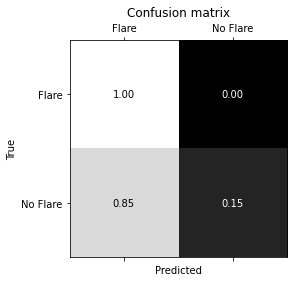

In [11]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)

## FAQ

- **The results don't look great... why?** From the confusion matrix in Section 6, when faced with the test dataset (i.e., data not used for training or validation), the model predicts a large fraction of false positive flare events, and consequently not enough true negative flare events).
The published models from [Feinstein et al. 2020](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) perform *much better*, and the confusion matrix **should look more like the results shown below**.
We note that in this notebook we are using a subset of the available training data, and we are training the model for only a subset of the optimal number of epochs for space and time considerations, but you are welcome to augment these restrictions, and as always check out [the `stella` repository](https://adina.feinste.in/stella/) for more information!

6/6 [==============================] - 0s 3ms/step


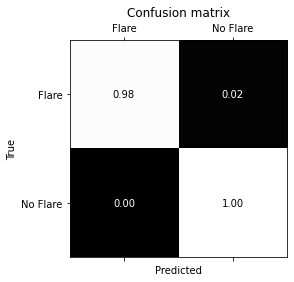

In [12]:
file_url = 'https://archive.stsci.edu/hlsps/stella/hlsp_stella_tess_ensemblemodel_s042_tess_v0.1.0_cnn.h5'
pretrained_model = load_model(download_file(file_url, cache=True, show_progress=True))

plot_confusion_matrix(pretrained_model, ds.test_data, ds.test_labels)

- **Can I improve the model by increasing the number of epochs its training for?**
We only trained for 20 epochs, which is many fewer than the published model.
Go back to Section 4 ("Train the CNN to perform a classification task") and increase the number of epochs to 100 (or more!) and train again.
Does your model perform better?
Your results may look better/worse/different from the published results due to the stochastic nature of training. 


- **Can I try a different model?  I think the results could be improved.**
Yes! You can try adding layers, swapping out the max pooling, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate.
Experiment and see what model changes give the best results.
You should be aware: when you start training again, you pick up where your model left off.
If you want to "reset" your model to epoch 0 and random weights, you should run the cells to make and compile the model again.


- **I want to test my model on my training data!**
No.
You will convince yourself that your results are much better than they actually are.
Always keep your training, validation, and testing sets completely separate!   

## Extensions/Exercises

- **Is the model "overfitting"?**
Using the results of the model's `history` (saved as a result of the model training process), investigate the behavior of the training and validation losses and accuracies as a function of training epoch.
Make a plot or two!
How do the training and validation losses compare?
How do the training and validation accuracies compare?
If the loss for the validation set is higher than for the training set (and conversely, the accuracy for the validation set is lower than for the training set), the model may be suffering from [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).


- **Try applying this model to a new dataset**
Using the built-in functionality provided by the `stella` package, you can pre-process your own 2-minute cadence TESS light curves and predict flares. 

## About this Notebook

**Author:**  
Claire Murray, Data Scientist, cmurray1@stsci.edu
    
**Additional Contributors:**  
Yotam Cohen, STScI Staff Scientist, ycohen@stsci.edu

**Info:**  
This notebook is based on the [`stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) software package for the CNN used in ["Flare Statistics for Young Stars from a Convolutional Neural Network Analysis of TESS Data"](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract), Adina D. Feinstein et al. Astronomical Journal, Volume 160, Issue 5, November 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Data Scientist, mntampaka@stsci.edu.

**Updated On:** 2022-5-25

## Citations

If you use this CNN, `stella`, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the CNN](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract)
* [Citing `stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)



[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 